# Analysis and plotting of RBD depletions for sera samles

### Set up Analysis

Import packages.

In [23]:
import itertools
import math
import os
import re
import warnings

from IPython.display import display, HTML

import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt
from mizani.formatters import scientific_format
import natsort

from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import numpy as np
import pandas as pd
from plotnine import *

import yaml
plt.rcParams['svg.fonttype'] = 'none'


In [24]:
warnings.simplefilter('ignore')

Read config file.

In [25]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Use seaborn theme and change font:

In [26]:
theme_set(theme_seaborn(style='white', context='talk', font_scale=1))
plt.style.use('seaborn-white')

In [27]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

## Titration ELISAs for pseudovirus assays

### Read ELISA Titration Data

In [28]:
elisa_pv_df_1 = pd.read_csv(config['RBD_depletion_repeat'])

elisa_pv_df_1 = (pd.melt(elisa_pv_df_1, 
                        id_vars=[ 'serum', 'depleted', 'round', 'ligand', 'plate', 'group'], 
                        var_name='dilution_factor', 
                        value_name='OD450'
                       )
                .assign(dilution_factor=lambda x: x['dilution_factor'].astype(int))
               )

elisa_pv_df_1 = (elisa_pv_df_1
                .assign(depleted= pd.Categorical(elisa_pv_df_1['depleted'], categories=['pre', 'post'], ordered=True),
                        dilution=lambda x: 1/x['dilution_factor'],
               )
                .sort_values('serum', key=lambda x: np.argsort(natsort.index_natsorted(x)))
       )

display(elisa_pv_df_1.head())  # display first few lines

,serum,depleted,round,ligand,plate,group,dilution_factor,OD450,dilution
8,child-2-born2020,pre,pre-pandemic-pool,XBB15-RBD,plate6,child,100,0.1125,0.010000
9,child-2-born2020,pre,no_depletion,XBB15-RBD,plate6,child,100,3.0487,0.010000
10,child-2-born2020,post,round_5,XBB15-RBD,plate6,child,100,0.0538,0.010000
25,child-2-born2020,pre,pre-pandemic-pool,XBB15-RBD,plate6,child,300,0.0657,0.003333
26,child-2-born2020,pre,no_depletion,XBB15-RBD,plate6,child,300,2.5364,0.003333


In [29]:
frames = [elisa_pv_df_1]
elisa_pv_df = pd.concat(frames)

In [30]:
# elisa_pv_df = pd.merge(elisa_pv_df, sample_information,
#                     left_on='serum', right_on='serum_org')
# elisa_pv_df.drop('serum_x', axis=1, inplace=True)
# elisa_pv_df = elisa_pv_df.rename(columns={"serum_y": "serum"}, errors="raise")
# elisa_pv_df

In [31]:
elisa_pv_df_adult = elisa_pv_df.loc[elisa_pv_df['group'] == 'adult']
elisa_pv_df_child = elisa_pv_df.loc[elisa_pv_df['group'] == 'child']
elisa_pv_df_infant = elisa_pv_df.loc[elisa_pv_df['group'] == 'infant']
elisa_pv_df_infantpre = elisa_pv_df.loc[elisa_pv_df['group'] == 'infant-pre']


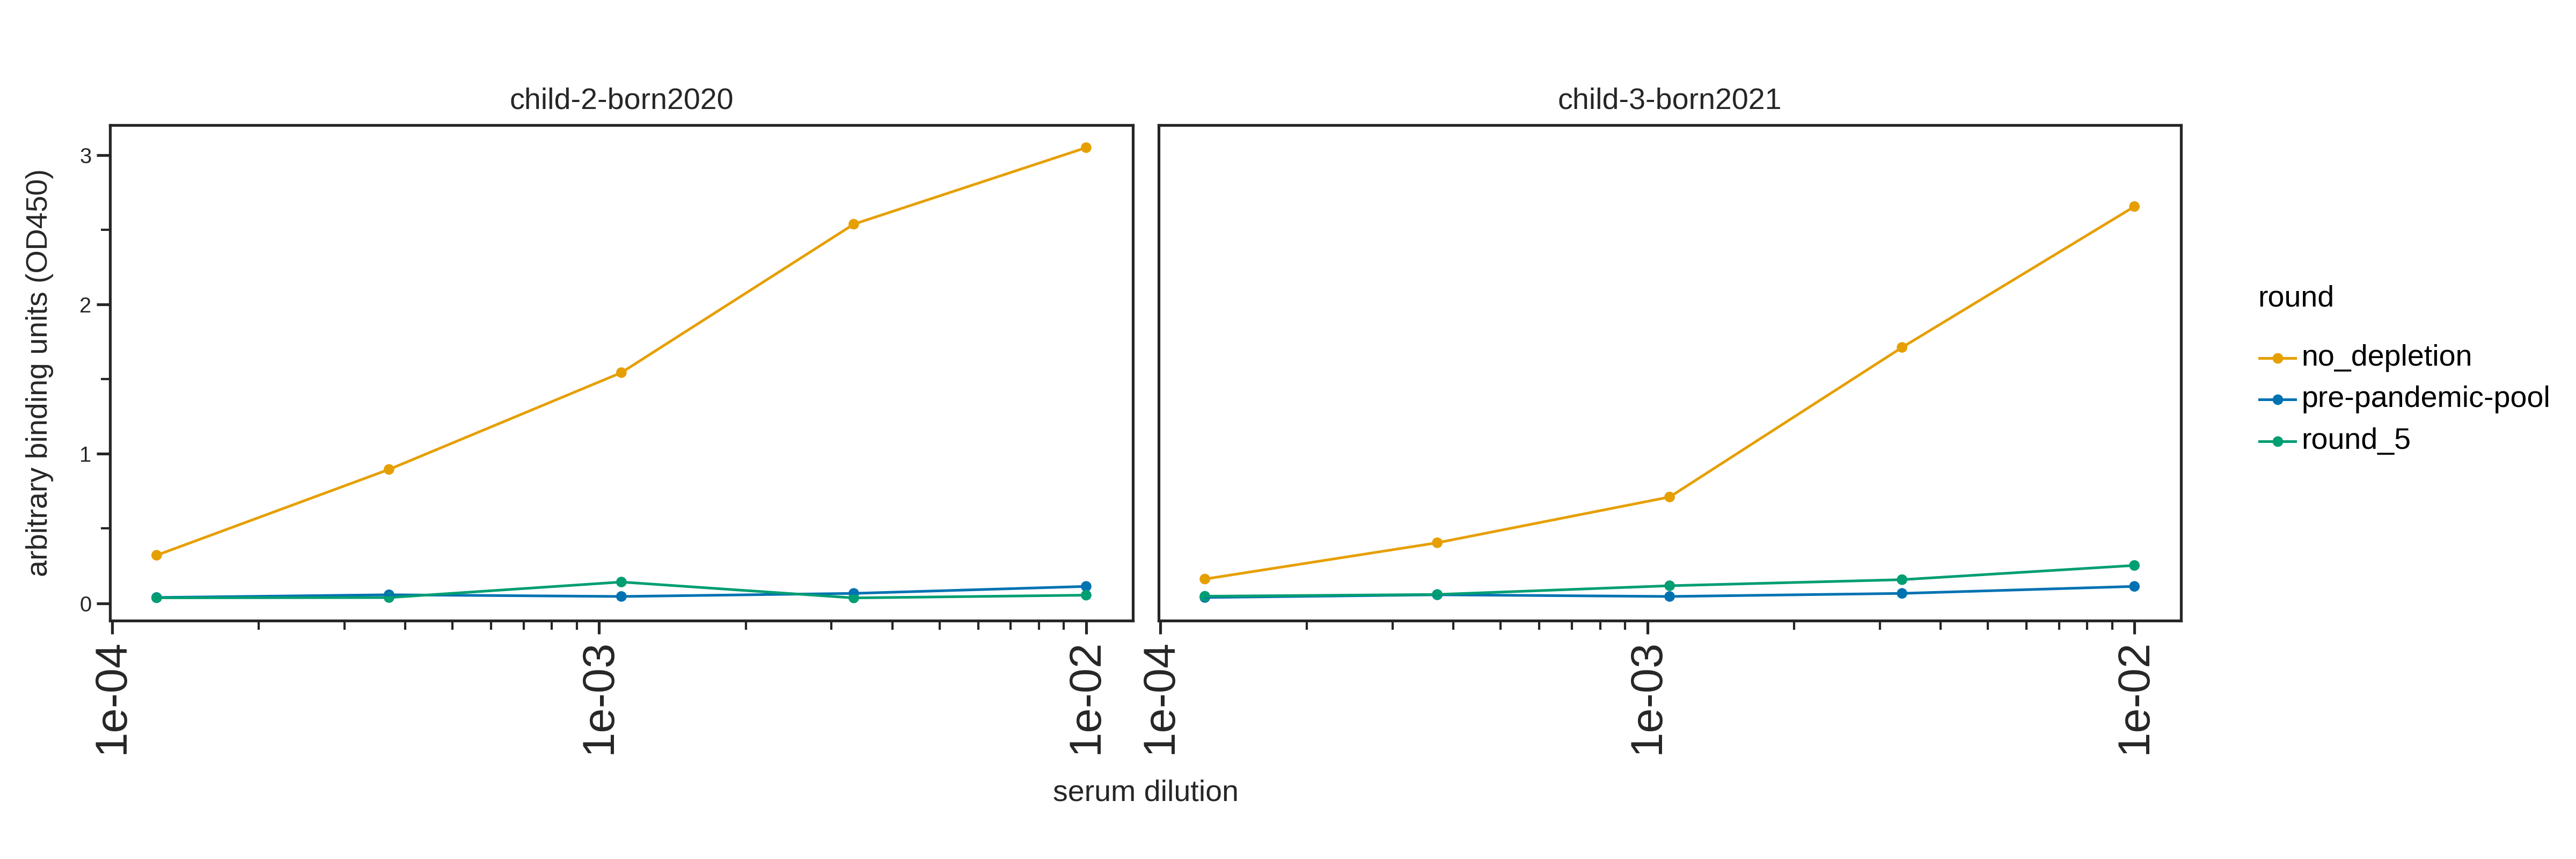

In [32]:
nconditions = elisa_pv_df['serum'].nunique()
ncol = np.minimum(6, nconditions)
nrow = math.ceil(nconditions / ncol)

colours = ('#E69F00','#0072B2','#009E73','#F0E442','#56B4E9',)

RBD_depletion_child = (
    ggplot((elisa_pv_df_child
            .assign(serum=lambda x: pd.Categorical(x['serum'], 
                                                   natsort.natsorted(x['serum'].unique()), 
                                                   ordered=True))
           ),
           aes('dilution', 
               'OD450', 
               color='round'
              )) +
    geom_point(size=3) +
    geom_path(aes(color='round'), size=1) +
    scale_x_log10(name='serum dilution', labels=scientific_format(digits=0)) +
    facet_wrap('~ serum', ncol=2) +
    theme(figure_size=(4 * ncol, 4 * nrow),
          axis_text_x=element_text(size=30,angle=90),
          subplots_adjust={'hspace':0.35},
          strip_background_x=element_blank(),
          strip_text_x=element_text(size=20),
          legend_text=element_text(size=20),
          legend_title=element_text(size=20),
          axis_title_x=element_text(size=20),
          axis_title_y=element_text(size=20)
         ) +
    scale_color_manual(values=colours) +
    scale_shape_manual(values=['o', 'x']) +
    ylab('arbitrary binding units (OD450)')
    )


# RBD_depletion_child.save("results/RBD_depletion_child.svg", format="svg")
# RBD_depletion_child.save("results/RBD_depletion_child.png", format="png", dpi=300)
RBD_depletion_child.draw()


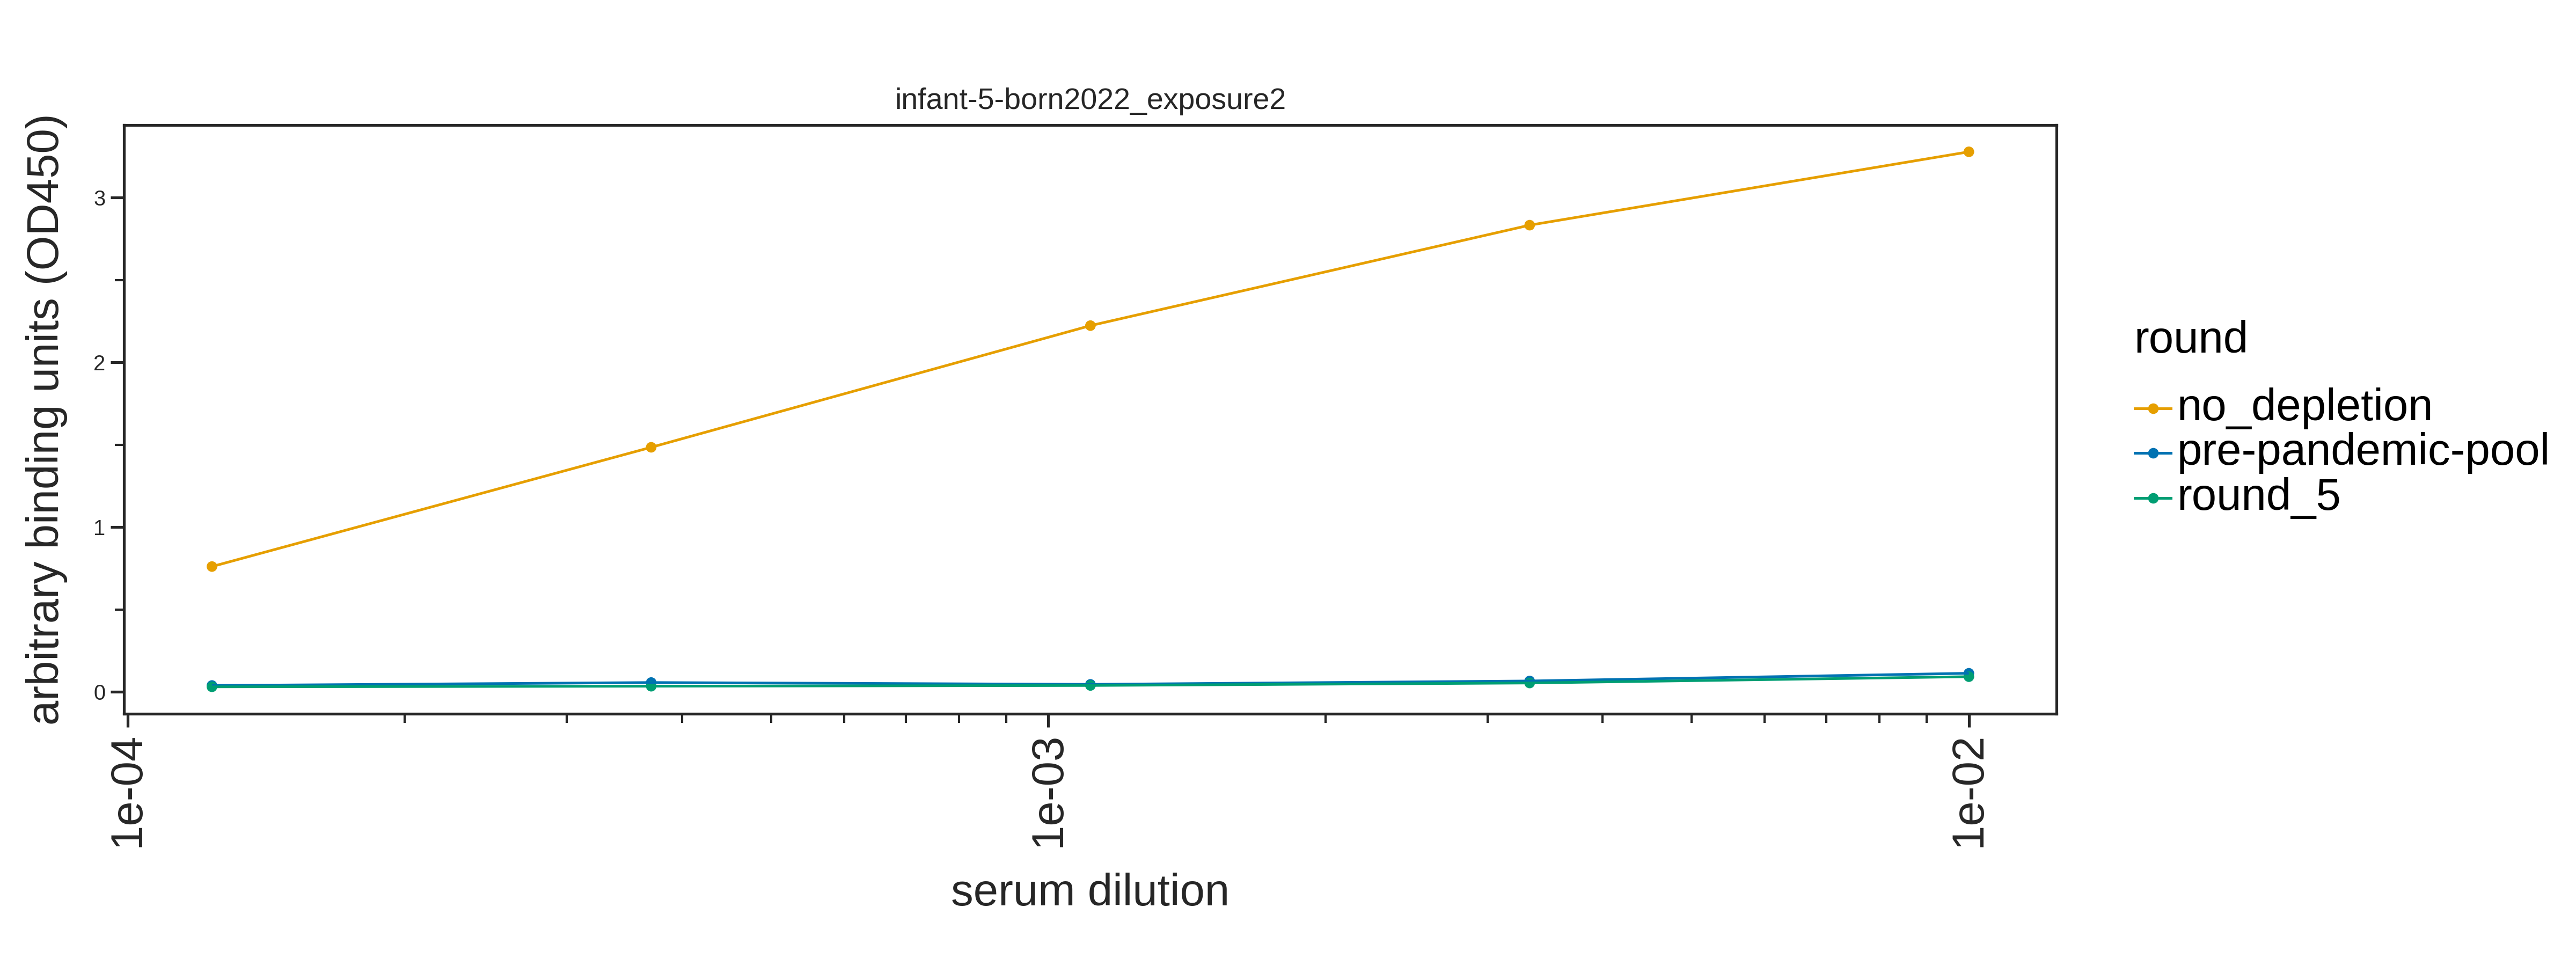

In [33]:
nconditions = elisa_pv_df['serum'].nunique()
ncol = np.minimum(6, nconditions)
nrow = math.ceil(nconditions / ncol)

colours = ('#E69F00','#0072B2','#009E73','#F0E442','#56B4E9',)

RBD_depletion_infant = (
    ggplot((elisa_pv_df_infant
            .assign(serum=lambda x: pd.Categorical(x['serum'], 
                                                   natsort.natsorted(x['serum'].unique()), 
                                                   ordered=True))
           ),
           aes('dilution', 
               'OD450', 
               color='round'
              )) +
    geom_point(size=3) +
    geom_path(aes(color='round'), size=1) +
    scale_x_log10(name='serum dilution', labels=scientific_format(digits=0)) +
    facet_wrap('~ serum', ncol=4) +
    theme(figure_size=(4 * ncol, 4.5 * nrow),
          axis_text_x=element_text(size=30,angle=90),
          subplots_adjust={'hspace':0.35},
          strip_background_x=element_blank(),
          strip_text_x=element_text(size=20),
          legend_text=element_text(size=30),
          legend_title=element_text(size=30),
          axis_title_x=element_text(size=30),
          axis_title_y=element_text(size=30)
         ) +
    scale_color_manual(values=colours) +
    scale_shape_manual(values=['o', 'x']) +
    ylab('arbitrary binding units (OD450)')
    )


# RBD_depletion_infant.save("results/RBD_depletion_infant.svg", format="svg")
# RBD_depletion_infant.save("results/RBD_depletion_infant.png", format="png", dpi=300)
RBD_depletion_infant.draw()


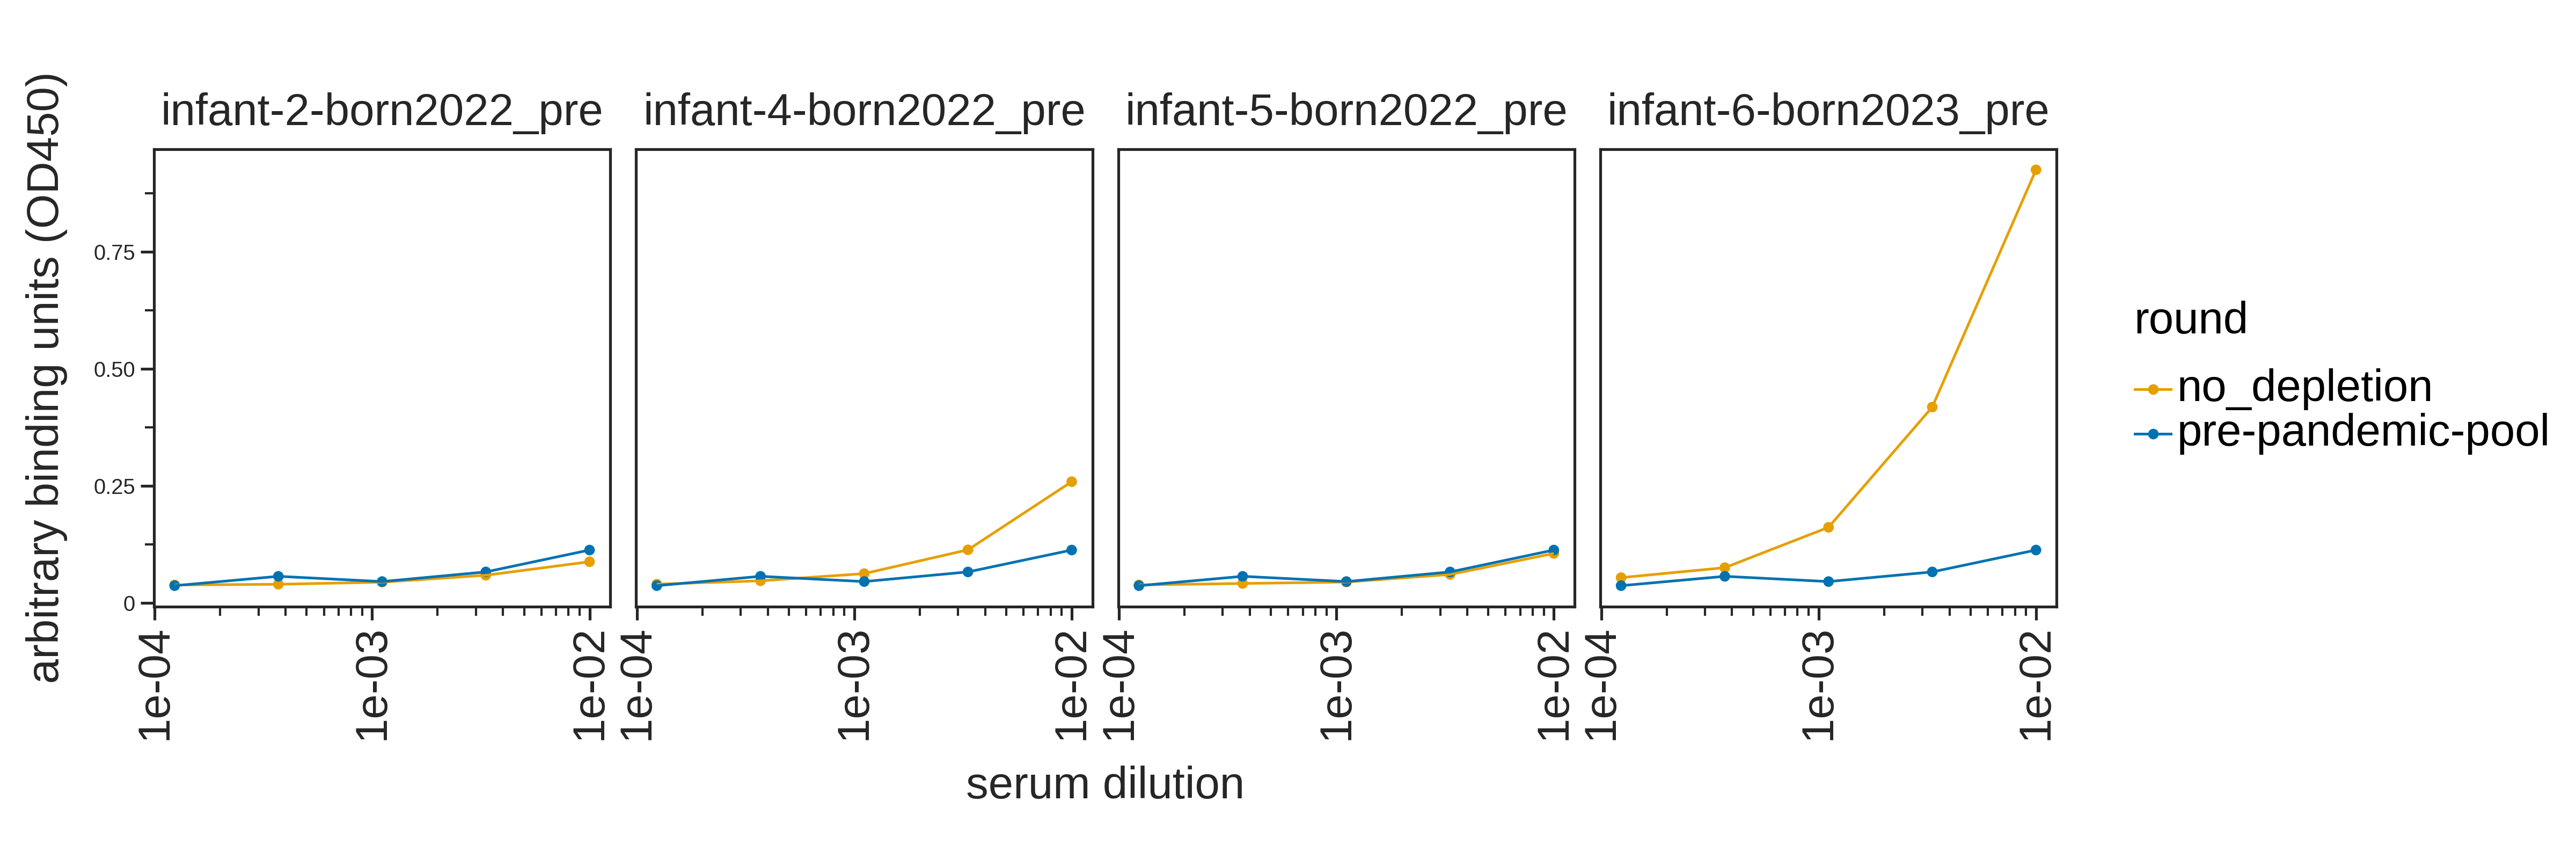

In [34]:
nconditions = elisa_pv_df['serum'].nunique()
ncol = np.minimum(6, nconditions)
nrow = math.ceil(nconditions / ncol)

colours = ('#E69F00','#0072B2','#009E73','#F0E442','#56B4E9',)

RBD_depletion_infantpre = (
    ggplot((elisa_pv_df_infantpre
            .assign(serum=lambda x: pd.Categorical(x['serum'], 
                                                   natsort.natsorted(x['serum'].unique()), 
                                                   ordered=True))
           ),
           aes('dilution', 
               'OD450', 
               color='round'
              )) +
    geom_point(size=3) +
    geom_path(aes(color='round'), size=1) +
    scale_x_log10(name='serum dilution', labels=scientific_format(digits=0)) +
    facet_wrap('~ serum', ncol=4) +
    theme(figure_size=(4 * ncol, 4 * nrow),
          axis_text_x=element_text(size=30,angle=90),
          subplots_adjust={'hspace':0.35},
          strip_background_x=element_blank(),
          strip_text_x=element_text(size=30),
          legend_text=element_text(size=30),
          legend_title=element_text(size=30),
          axis_title_x=element_text(size=30),
          axis_title_y=element_text(size=30)
         ) +
    scale_color_manual(values=colours) +
    scale_shape_manual(values=['o', 'x']) +
    ylab('arbitrary binding units (OD450)')
    )


# RBD_depletion_infantpre.save("results/RBD_depletion_infantpre.svg", format="svg")
# RBD_depletion_infantpre.save("results/RBD_depletion_infantpre.png", format="png", dpi=300)
RBD_depletion_infantpre.draw()


In [39]:
elisa_pv_df_alt= elisa_pv_df.loc[elisa_pv_df['group'].isin(['infant', 'infant-pre'])]


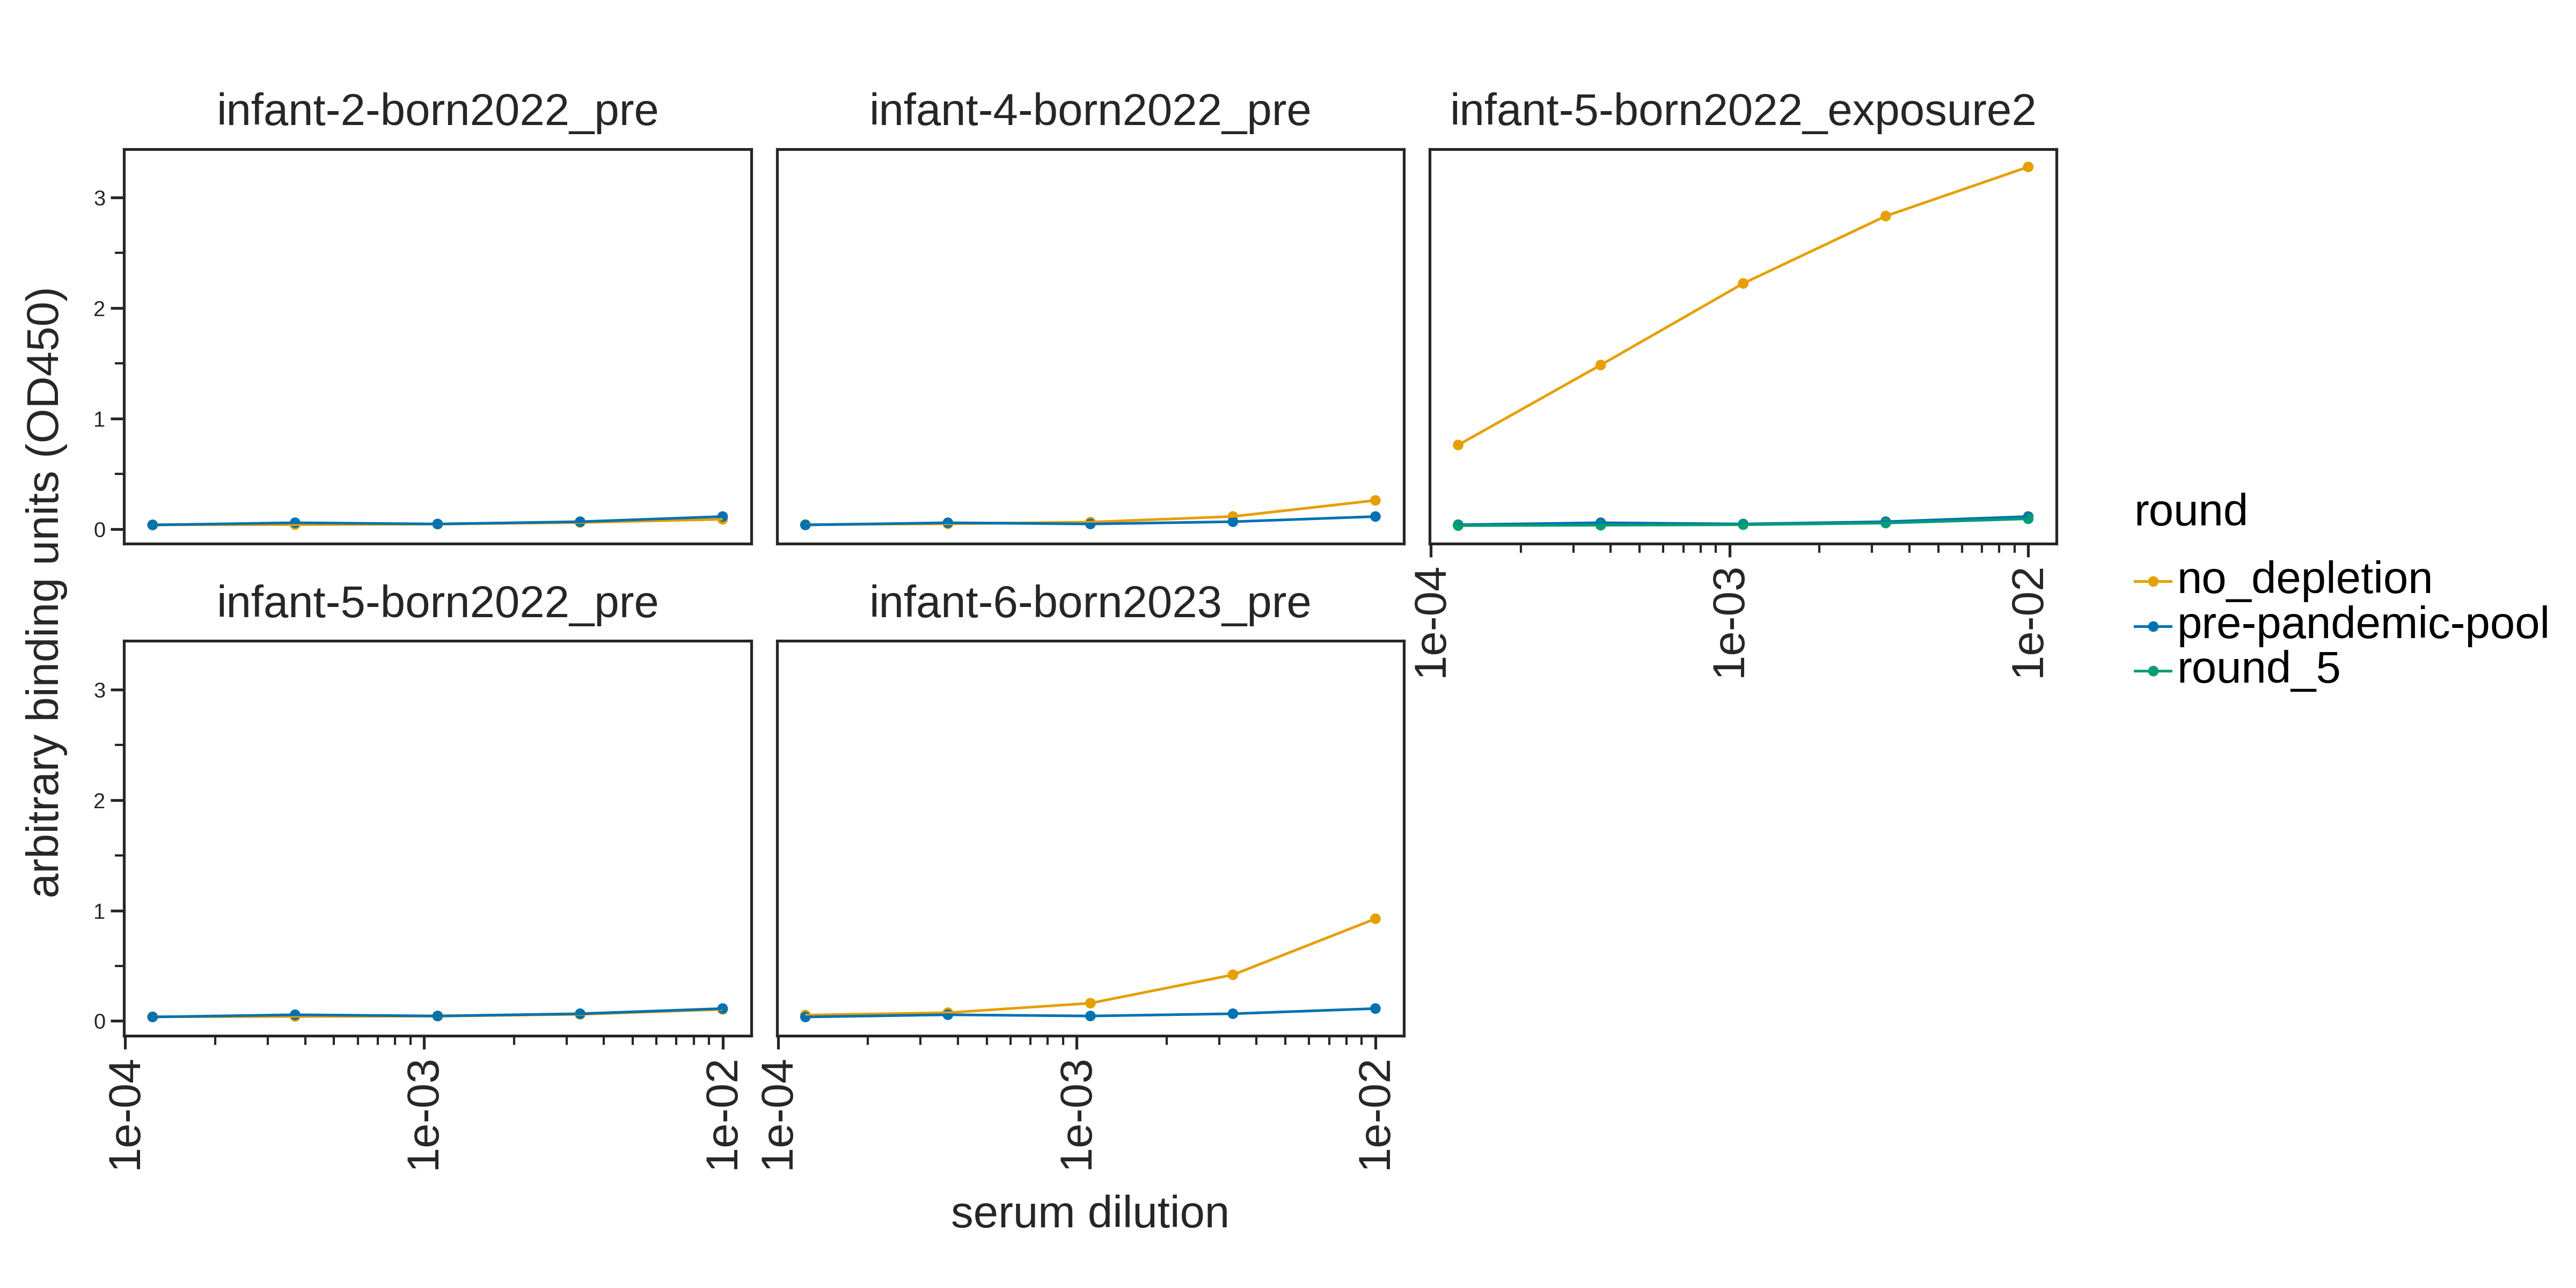

In [44]:
colours = ('#E69F00','#0072B2','#009E73','#F0E442','#56B4E9',)

RBD_depletion_alt = (
    ggplot((elisa_pv_df_alt
            .assign(serum=lambda x: pd.Categorical(x['serum'], 
                                                   natsort.natsorted(x['serum'].unique()), 
                                                   ordered=True))
           ),
           aes('dilution', 
               'OD450', 
               color='round'
              )) +
    geom_point(size=3) +
    geom_path(aes(color='round'), size=1) +
    scale_x_log10(name='serum dilution', labels=scientific_format(digits=0)) +
    facet_wrap('~ serum', ncol=3) +
    theme(figure_size=(4 * ncol, 6 * nrow),
          axis_text_x=element_text(size=30,angle=90),
          subplots_adjust={'hspace':0.35},
          strip_background_x=element_blank(),
          strip_text_x=element_text(size=30),
          legend_text=element_text(size=30),
          legend_title=element_text(size=30),
          axis_title_x=element_text(size=30),
          axis_title_y=element_text(size=30)
         ) +
    scale_color_manual(values=colours) +
    scale_shape_manual(values=['o', 'x']) +
    ylab('arbitrary binding units (OD450)')
    )


RBD_depletion_alt.save("results/RBD_depletion_infantpre_alt.svg", format="svg")
RBD_depletion_alt.save("results/RBD_depletion_infantpre_alt.png", format="png", dpi=300)
RBD_depletion_alt.draw()
